## Анализ киберугроз 2015–2024

Краткое исследование данных об инцидентах: страны, тренды, отрасли и самые затратные атаки.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Единый стиль и поддержка кириллицы
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["font.family"] = "DejaVu Sans"

# Хелпер для подписей на барах
def annotate_bars(ax, fmt="{:.0f}"):
    for p in ax.patches:
        value = p.get_width() if p.get_width() > p.get_height() else p.get_height()
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        if p.get_width() >= p.get_height():  # горизонтальные бары
            ax.text(x + max(value*0.005, 0.2), y, fmt.format(value), va="center")
        else:  # вертикальные бары
            ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height() + max(value*0.01, 0.2), fmt.format(value), ha="center")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/global-cybersecurity-threats-2015-2024/Global_Cybersecurity_Threats_2015-2024.csv


Чтение данных


In [2]:
df = pd.read_csv('/kaggle/input/global-cybersecurity-threats-2015-2024/Global_Cybersecurity_Threats_2015-2024.csv')
df

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68
...,...,...,...,...,...,...,...,...,...,...
2995,UK,2021,Ransomware,Government,51.42,190694,Unknown,Social Engineering,Firewall,52
2996,Brazil,2023,SQL Injection,Telecommunications,30.28,892843,Hacker Group,Zero-day,VPN,26
2997,Brazil,2017,SQL Injection,IT,32.97,734737,Nation-state,Weak Passwords,AI-based Detection,30
2998,UK,2022,SQL Injection,IT,32.17,379954,Insider,Unpatched Software,Firewall,9



Итог:
- Нет пропущенных значений в данных.
- Все колонки полностью заполнены.

Топ-10 стран по числу атак


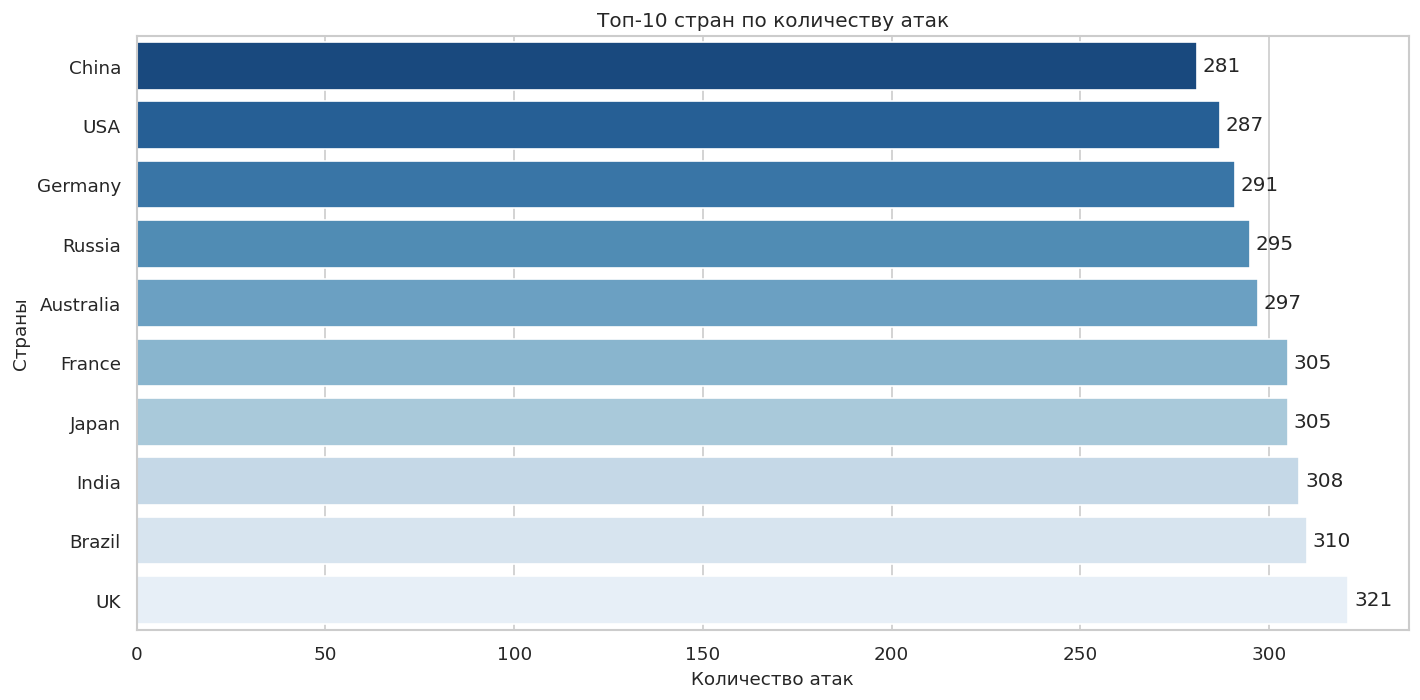

In [3]:
country_counts = df['Country'].value_counts().nlargest(10).sort_values()
plt.figure(figsize=(12,6))
ax = sns.barplot(x=country_counts.values, y=country_counts.index, palette='Blues_r')
plt.title('Топ-10 стран по количеству атак')
plt.xlabel('Количество атак')
plt.ylabel('Страны')
annotate_bars(ax)
plt.tight_layout()
plt.show()

Вывод:
- Лидируют цифрово развитые страны с большой поверхностью атаки и высоким уровнем выявления.
- Больше инцидентов не обязательно означает «хуже защита» — влияет масштаб и отчётность.
- Практика: приоритизировать меры в странах-лидерах и смотреть плотность атак (на пользователя/компанию).

Динамика атак по годам


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


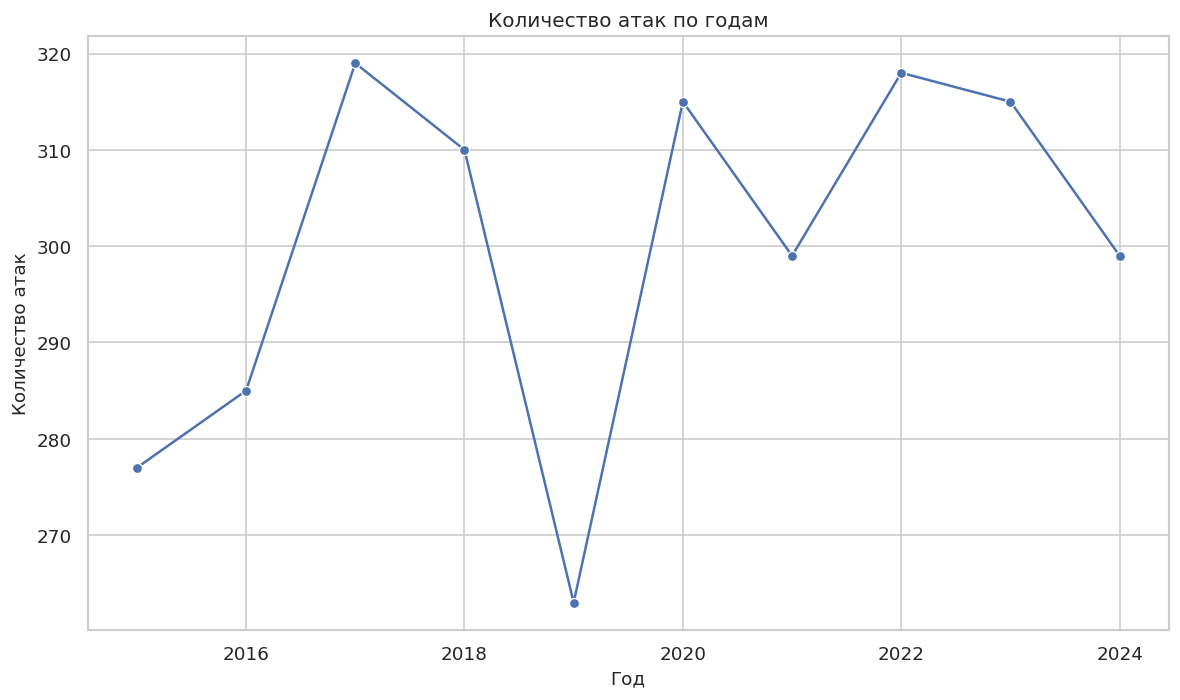

In [4]:
attacks_by_year = df.groupby('Year').size().sort_index()
plt.figure(figsize=(10,6))
ax = sns.lineplot(x=attacks_by_year.index, y=attacks_by_year.values, marker='o')
plt.title('Количество атак по годам')
plt.xlabel('Год')
plt.ylabel('Количество атак')
ax.yaxis.get_major_locator().set_params(integer=True)
plt.grid(True)
plt.tight_layout()
plt.show() 

Вывод:
- Наблюдается рост инцидентов на фоне цифровизации, удалёнки и новых векторов (облака, цепочки поставок).
- Пики часто связаны с глобальными событиями/массовыми кампаниями.
- Практика: планировать бюджеты с учётом роста, инвестировать в мониторинг и автоматизацию реагирования.

Типы атак по отраслям 


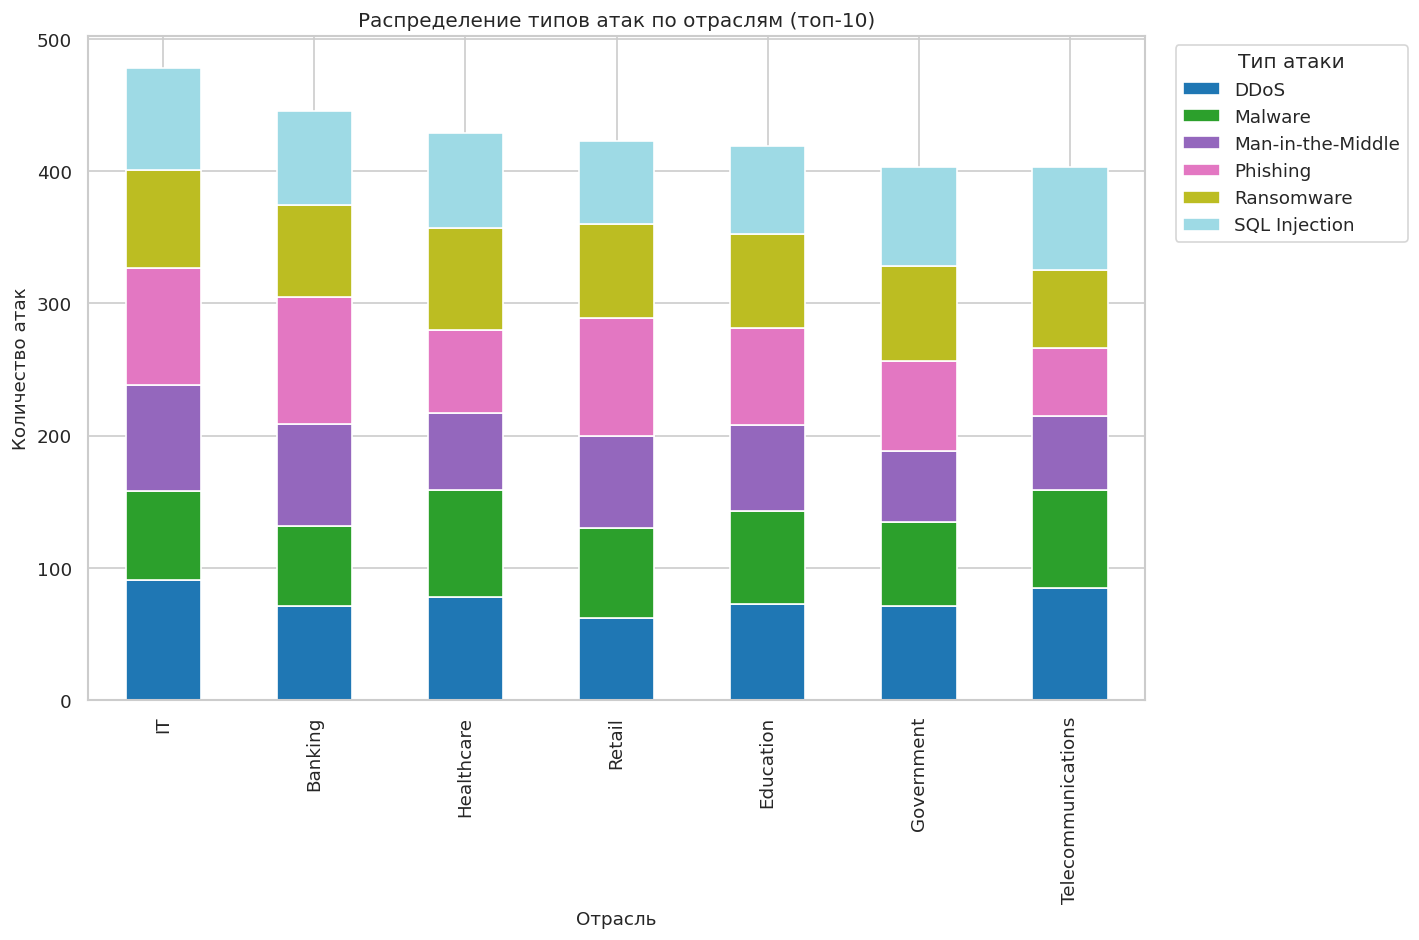

In [5]:
top_industries = df['Target Industry'].value_counts().index[:10]
subset = df[df['Target Industry'].isin(top_industries)]
pivot = (subset.groupby(['Target Industry','Attack Type']).size()
               .unstack(fill_value=0))
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
ax = pivot.plot(kind='bar', stacked=True, figsize=(12,8), colormap='tab20')
plt.title('Распределение типов атак по отраслям (топ-10)')
plt.xlabel('Отрасль')
plt.ylabel('Количество атак')
plt.legend(title='Тип атаки', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show() 

Вывод: здравоохранение, банкинг и IT имеют высокую концентрацию событий из-за критичности данных и монетизации.

Топ-10 самых затратных атак


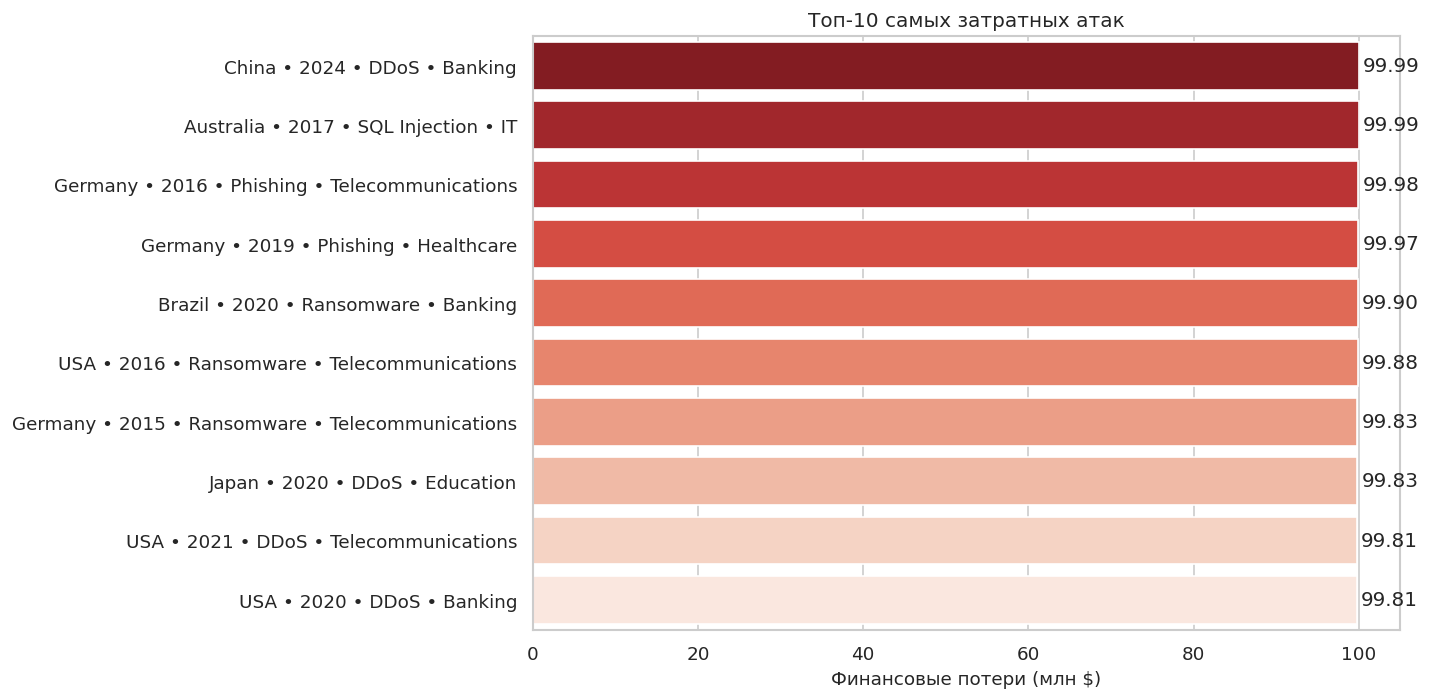

In [6]:
top_losses = df[['Country','Year','Attack Type','Target Industry','Financial Loss (in Million $)','Number of Affected Users']].sort_values(by='Financial Loss (in Million $)', ascending=False)
top_10 = top_losses.head(10).copy()
top_10['Инцидент'] = (top_10['Country'] + ' • ' + top_10['Year'].astype(str) +
                      ' • ' + top_10['Attack Type'] + ' • ' + top_10['Target Industry'])
plt.figure(figsize=(12,6))
ax = sns.barplot(data=top_10, x='Financial Loss (in Million $)', y='Инцидент', palette='Reds_r')
plt.title('Топ-10 самых затратных атак')
plt.xlabel('Финансовые потери (млн $)')
plt.ylabel('')
annotate_bars(ax, fmt="{:.2f}")
plt.tight_layout()
plt.show()

Вывод: наибольшие убытки не всегда там, где больше инцидентов — важна тяжесть.

Общий вывод:
- Атаки растут по объёму и сложности → нужно управление уязвимости и обучение работников по предотвращению.
- Необходимо регулярное тестирование на уязвимости.